In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imammukhri","key":"eb9766ded639cf23df08187c5e57f8e0"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jul 29 14:05 kaggle.json


In [3]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

 85% 49.0M/57.4M [00:01<00:00, 30.3MB/s]
100% 57.4M/57.4M [00:01<00:00, 42.4MB/s]


In [6]:
!unzip /content/neu-metal-surface-defects-data.zip

Archive:  /content/neu-metal-surface-defects-data.zip
  inflating: NEU Metal Surface Defects Data/Thumbs.db  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_1.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_10.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_100.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_101.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_102.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_103.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_104.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_105.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_106.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_107.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_108.bmp  
  inflating: NEU Metal Surface Defects Data/test/Crazing/Cr_109.bmp  
  inflating: NEU Metal Surface Defects Data/test/Incl

In [7]:
import os

train_dir = '/content/NEU Metal Surface Defects Data/train'
val_dir = '/content/NEU Metal Surface Defects Data/valid'
test_dir='/content/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/content/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/content/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/content/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/content/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['test', 'Thumbs.db', 'valid', 'train']
Train Direcorty:  ['Crazing', 'Inclusion', 'Scratches', 'Rolled', 'Pitted', 'Patches']
Test Direcorty:  ['Crazing', 'Inclusion', 'Scratches', 'Rolled', 'Pitted', 'Patches']
Validation Direcorty:  ['Crazing', 'Inclusion', 'Scratches', 'Rolled', 'Pitted', 'Patches']


In [8]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 199, 199, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [14]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 [==============================] - 48s 115ms/step - loss: 1.9061 - accuracy: 0.3182 - val_loss: 1.4141 - val_accuracy: 0.5417
Epoch 2/20
166/166 [==============================] - 18s 109ms/step - loss: 1.2940 - accuracy: 0.5308 - val_loss: 0.8723 - val_accuracy: 0.5694
Epoch 3/20
166/166 [==============================] - 18s 110ms/step - loss: 0.9514 - accuracy: 0.6824 - val_loss: 1.4213 - val_accuracy: 0.4167
Epoch 4/20
166/166 [==============================] - 18s 111ms/step - loss: 0.7570 - accuracy: 0.7512 - val_loss: 0.2451 - val_accuracy: 0.9722
Epoch 5/20
166/166 [==============================] - 19s 114ms/step - loss: 0.6665 - accuracy: 0.8007 - val_loss: 0.2975 - val_accuracy: 0.9167
Epoch 6/20
166/166 [==============================] - 19s 112ms/step - loss: 0.6020 - accuracy: 0.8243 - val_loss: 0.2302 - val_accuracy: 0.9167
Epoch 7/20
166/166 [==============================] - 19s 111ms/step - loss: 0.4896 - accuracy: 0.8690 - val_loss: 0.0671 - val_ac

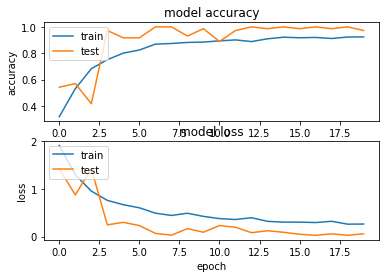

In [15]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [16]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = '/content/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [17]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [18]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [19]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [20]:
x_test = x_test.astype('float32')/255

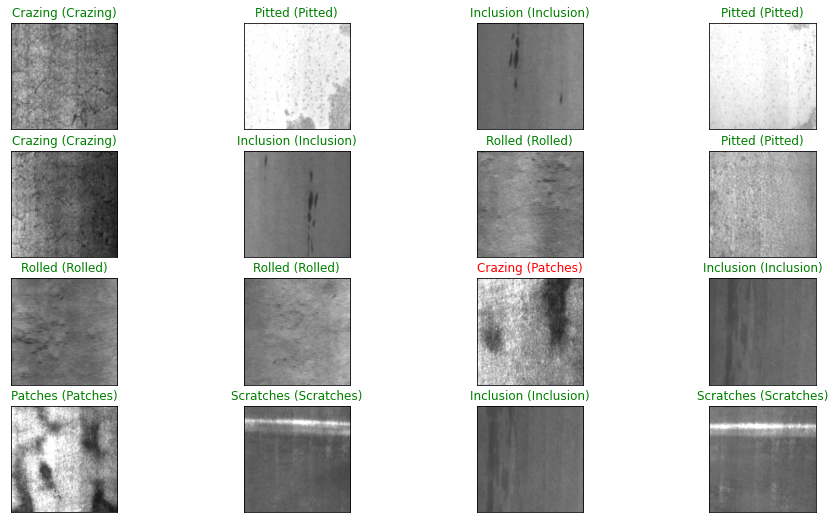

In [21]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))